In [29]:
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import multiprocessing as multi
import numpy.random as random
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, wait, as_completed

In [69]:
class SSA(object):
    t_matrix = None
    eigs = None
    pcs = None
    rcs = None

    def __init__(self, data, m):
        self.data = np.array(data)
        self.m = m
        self.n = len(self.data)
        self.data = self.data.reshape((self.n, 1))
        self._compute_t_matrix()
        self._compute_eigs()
        self._compute_pcs()

    def _compute_t_matrix(self):
        n = self.n
        m = self.m
        data = self.data
        covariances = [(1 / (n - j)) * np.matmul(data.T[0, 0:n - j - 1], data[j:n - 1, 0]) for j in range(m)]
        toeplitz_matrix = np.array([covariances[abs(i - j)]
                                    for i, j in it.product(*([range(m)] * 2))]).reshape((m, m))
        self.t_matrix = toeplitz_matrix

    def _compute_eigs(self):
        eig_values, eig_vectors = np.linalg.eigh(self.t_matrix)
        eigs = [{"value": value, "vector": vector} for value, vector in
                zip(eig_values, list(eig_vectors.T))]
        eigs_sorted = sorted(eigs, key=lambda e: e["value"],
                             reverse=True)  # Sort eigenvalues and eigenvectors by descending eigenvalue
        self.eigs = eigs_sorted

    def _compute_pcs(self):
        k = 0
        n = self.n
        m = self.m
        eigs = self.eigs
        pcs = np.vstack([[np.matmul(self.data[i:i + m, 0], eigs[k]["vector"]) for i in range(n - m + 1)]
                         for k in range(len(eigs))])
        self.pcs = pcs

    def get_rcs(self, subset):
        m = self.m
        n = self.n
        pcs = self.pcs
        eigs = self.eigs
        rcs = []
        for i in range(1, n + 1):
            s = 0
            rc = (1 / len(self._get_pc_window(i))) * sum(
                [np.matmul(pcs[s][self._get_pc_window(i)].T, eigs[s]["vector"][self._get_eig_window(i)])
                 for s in subset])
            rcs.append(rc)
        return rcs

    def _get_pc_window(self, i):
        m = self.m
        n = self.n
        if 1 <= i <= m - 1:
            return range(i - 1, -1, -1)  # close to beginning: from (i - 1)th pc to zeroth pc (descending)
        elif n - m + 2 <= i <= n:
            return range(n - m, i - m - 1, -1)  # close to end: from (n - m)th pc to (i - m)th pc (descending).
        else:
            return range(i - 1, i - m - 1, -1) # 

    def _get_eig_window(self, i):
        m = self.m
        n = self.n
        if 0 <= i <= m - 1:
            return range(0, i)  # close to beginning of series
        elif n - m + 2 <= i <= n:
            return range(i - n + m - 1, m)  # close to end of series
        else:
            return range(0, m)

    def _get_diags(self, mat):
        rows = len(mat)
        cols = len(mat[0])
        diags = [[mat[sum_ - k][k]
                  for k in range(sum_ + 1)
                  if (sum_ - k) < rows and k < cols]
                 for sum_ in range(rows + cols - 1)]
        return diags

    def find_statistical_order(self):
        eigs = self.eigs
        m = self.m
        n = self.n
        
        # Generate 100 white noise processes
        with ProcessPoolExecutor() as executor:
            v_futures = [executor.submit(self._generate_white_noise) for _ in range(100)]
        v = [f.result() for f in wait(v_futures).done]
        
        for p in range(0, len(eigs) - 1):
            # For a given order p, we reconstruct with subset of eigenvectors p+1... m
            subset = list(range(p + 1, m))
            noise_intervals = self._get_noise_intervals(v, subset)
            rcs = self.get_rcs(subset)
            c_ps = [(1 / (n - j)) * np.matmul(rcs[0:n - j - 1],
                                              rcs[j:n - 1]) for j in range(m)]
            beta_intervals = [self.get_beta_interval(c_p, noise_interval) for c_p, noise_interval in zip(c_ps, noise_intervals)]
            delta = np.amax([beta_interval[0] for beta_interval in beta_intervals], axis=0)
            gamma = np.amin([beta_interval[1] for beta_interval in beta_intervals], axis=0)
            if delta <= gamma:
                return p, (delta, gamma)
        return -1, None

    def _get_noise_intervals(self, v, subset):
        m = self.m
        n = self.n
        c_ws = []
        with ProcessPoolExecutor() as executor:
            c_ws = list(executor.map(self._get_noise_correlations, v, [subset]*len(v)))
        means, sems = np.mean(c_ws, axis=0), np.var(c_ws, axis=0)
        noise_intervals = [(mean-1.96*(var**0.5), mean+1.96*(var**0.5)) for mean, var in zip(means, sems)]
        return noise_intervals

    def _get_noise_correlations(self, w_ssa, subset):
        m = self.m
        n = self.n
        rc_w = w_ssa.get_rcs(subset)
        c_w = [(1 / (n - j)) * np.matmul(rc_w[0:n - j - 1],
                                         rc_w[j:n - 1]) for j in range(m)]
        return c_w

    def get_beta_interval(self, c_p, noise_interval):
        # If lower bound is negative and upper bound is positive, there's no upper
        # limit on beta
        if noise_interval[0] < 0 < noise_interval[1]:
            return max(c_p / noise_interval[0], c_p / noise_interval[1]), np.inf

        # If both lower bound and upper bound are positive: beta must be small enough
        # that c_p is greater than lower bound, large enough that c_p is less than
        # upper bound
        elif 0 < noise_interval[0] < noise_interval[1]:
            return c_p / noise_interval[1], c_p / noise_interval[0]

        # If both lower bound and upper bound are negative, beta must be large enough
        # that c_p is greater than lower bound, small enough that c_p is less than
        # upper bound
        elif noise_interval[0] < noise_interval[1] < 0:
            return c_p / noise_interval[0], c_p / noise_interval[1]

        elif noise_interval[0] == 0 or noise_interval[1] == 0:
            # if lower bound negative, beta must be large enough that c_p greater
            # than negative lower bound
            if noise_interval[0] < 0:
                return c_p / noise_interval[0], np.inf
            # if upper bound positive, beta must be large enough that c_p less than
            # upper bound
            elif noise_interval[1] > 0:
                return c_p / noise_interval[1], np.inf

        else:
            return np.nan, np.nan

    def _generate_white_noise(self):
        w_ssa = SSA(data=np.random.normal(0, 1, self.n), m=self.m)
        return w_ssa

In [9]:
def generate_process(sigma):
    om1 = (2/20)*np.pi
    om2 = (2/7)*np.pi
    phi1 = random.random()*2*np.pi
    phi2 = random.random()*2*np.pi
    y1 = [2*np.cos(om1*n+phi1) + np.cos(om2+phi2) for n in range(150)]
    w1 = random.normal(0, sigma, 150)
    return y1+w1

In [78]:
lags = 20
p1 = generate_process(2.5)
ssa = SSA(data=p1, m=lags)

$^{T_{x}}=\begin{bmatrix}
c(0) &  c(1) & . & . & . & c(M-1)\\ 
c(1) & c(0) & c(1) &  &  & .\\ 
. & c(1) & . & . &  & .\\ 
. &  &  & . & . & .\\ 
. &  &  & . & . & .\\ 
c(M-1) & . & . & . & c(1) & c(0)
\end{bmatrix}$

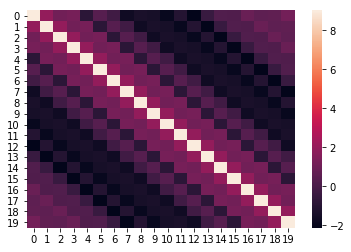

In [71]:
ax = sns.heatmap(ssa.t_matrix)
plt.show()

Since $T_{x}$ is symmetric, we can use numpy.eigh to find the eigenvalues and vectors.

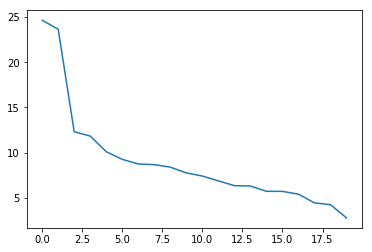

In [72]:
# could have something about spectral decomposition on p101
plt.plot([e["value"] for e in ssa.eigs])

kth PC <br>
$a_{i}^{k}=\sum_{j=1}^{M}x_{i+j}E_{j}^{k}, 0\leq i\leq N-M$

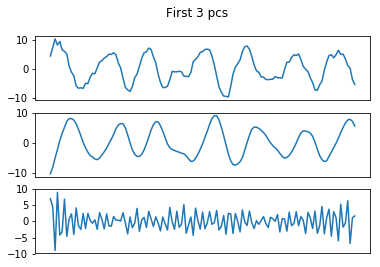

In [73]:
fig, axs = plt.subplots(3)
fig.suptitle('First 3 pcs')
for i in range(3):
    axs[i].set_xticks([])
    axs[i].plot(ssa.pcs[i])

In [ ]:
# timing, vectorisation
# RC indexing

$x_{i+j}=\sum_{k=1}^{M}a_{i}^{k}E_{j}^{k}, 1\leq j\leq M$
<br>Not a unique expansion
<br>Minimise:
$H_{A}(y)=\sum_{i=0}^{N-M}\sum_{j=1}^{M}\left (y_{i+j}-\sum_{k\in A}a_{i}^{k}E_{j}^{k}\right )^{2}$
<br> A least squares problem
<br> For PCs near the beginning of the series, $(R_{A}x)_{i}=\frac{1}{i}\sum_{j=1}^{i}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$, for $0\leq i\leq M-1$  
<br> For PCs near the end of the series, $(R_{A}x)_{i}=\frac{1}{i}\sum_{j=i-N+M}^{M}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$, for $N-M+2\leq i\leq N$
<br> For the rest,
<br> $(R_{A}x)_{i}=\frac{1}{M}\sum_{k=1}^{M}\sum_{k\in A}a_{i-j}^{k}E_{j}^{k}$ for $M\leq i\leq N-M+1$ 

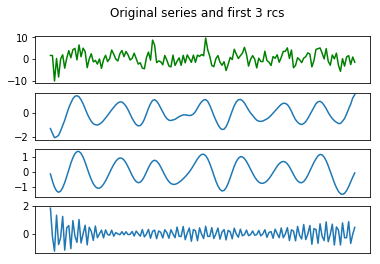

In [75]:
fig, axs = plt.subplots(4)
fig.suptitle('Original series and first 3 rcs')
axs[0].set_xticks([])
axs[0].plot(ssa.data, color="green")
for i in range(3):
    axs[i+1].set_xticks([])
    axs[i+1].plot(ssa.get_rcs(subset=[i]))

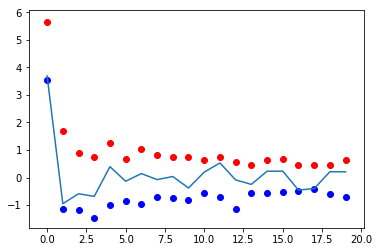

In [114]:
with ProcessPoolExecutor() as executor:
            v_futures = [executor.submit(ssa._generate_white_noise) for _ in range(100)]
v = [f.result() for f in wait(v_futures).done]
        
eigs = ssa.eigs
m = ssa.m
n = ssa.n
        
for p in range(0, len(eigs) - 1):
    # For a given order p, we reconstruct with subset of eigenvectors p+1... m
    subset = list(range(p + 1, m))
    noise_intervals = ssa._get_noise_intervals(v, subset)
    rcs = ssa.get_rcs(subset)
    c_ps = [(1 / (n - j)) * np.matmul(rcs[0:n - j - 1],
                                      rcs[j:n - 1]) for j in range(m)]
    beta_intervals = [ssa.get_beta_interval(c_p, noise_interval) 
                      for c_p, noise_interval in zip(c_ps, noise_intervals)]
    delta = np.amax([beta_interval[0] for beta_interval in beta_intervals], axis=0)
    gamma = np.amin([beta_interval[1] for beta_interval in beta_intervals], axis=0)
    if delta <= gamma:
        beta_value = (delta + gamma)/2
        plt.scatter(range(m), np.multiply(beta_value, [noise_interval[0] for
                                             noise_interval in noise_intervals]), color="blue")
        plt.scatter(range(m), np.multiply(beta_value, [noise_interval[1]
                                                      for noise_interval in noise_intervals]), color="red")
        plt.plot(c_ps)
        break

In [115]:
(delta, gamma)

(7.319890836880364, 7.946064807893048)

In [111]:
c_ps

[3.6890071652916134,
 -0.9501678237805062,
 -0.5895659266704429,
 -0.6854312790068853,
 0.3931527198131639,
 -0.13586112000015008,
 0.1431486105145767,
 -0.07613955415210243,
 0.03658094160472206,
 -0.3802126096213013,
 0.19527739397977606,
 0.5290882362883821,
 -0.08592735855679935,
 -0.24918479144217429,
 0.22790596854649317,
 0.2330192885194417,
 -0.4549525914203905,
 -0.40252098632263117,
 0.21077190060995757,
 0.20632972182856407]

In [112]:
(delta, gamma)

(7.497717899239887, 7.974332690241763)